<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/ders_kod/mmi512_Week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 8: Group Movement**

The Boid algorithm is a classic example of how simple rules can result in complex group behaviors, often observed in flocks of birds, schools of fish, and herds of animals.

The Boid algorithm was first introduced by Craig Reynolds in 1986, and it models the movement of a flock of birds based on three simple rules: separation, alignment, and cohesion. The separation rule ensures that birds avoid crowding each other, the alignment rule ensures that birds move in the same direction as their neighbors, and the cohesion rule ensures that birds stay close to each other.

In this notebook, we will use Python to simulate the behavior of a group of agents, which can represent birds, fish, or any other entity that exhibits swarm behavior. We will visualize the movement of these agents and observe how their collective behavior emerges from the simple rules of the Boid algorithm.

Let's get started by importing the necessary Python libraries and setting up the environment for our simulation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

- We will now define a global avoidance distance and also some utility functions that will be used in initialising the model

In [ ]:
DAVOIDANCE = 2

def unitvector(vec):
    nrm =  np.linalg.norm(vec)
    if nrm == 0:
        vec = np.random.rand(2)
    return vec / np.linalg.norm(vec)

def initialpositions(numboids, xlims, ylims, obstacleset):
    count = 0
    post = np.empty((1,2))
    while count < numboids:
        x = np.random.rand(1) * (xlims[1] - xlims[0]) + xlims[0]
        y = np.random.rand(1) * (ylims[1] - ylims[0]) + ylims[0]
        pos = np.array([x, y]).reshape((1,2))
        inflag = False
        for obstacle in obstacleset:
            posobs = obstacle.getposition()
            dist = np.linalg.norm(pos - posobs)
            if dist < obstacle.getradius():
                inflag = True
        if not inflag:
            post = np.concatenate([post, pos], axis=0)
            count += 1
    return post

def initialheadings(numboids):
    thetas = np.random.rand(numboids) * 2 * np.pi
    heads = np.zeros((numboids, 2))
    for ind in range(numboids):
        heads[ind, :] = np.array([np.cos(thetas[ind]), np.sin(thetas[ind])])
    return heads

def initialspeeds(numboids, minspeed, maxspeed):
    speeds = np.random.rand(numboids) * (maxspeed - minspeed) + minspeed
    return speeds

def cart2polar(xvec):
    th = np.arctan2(xvec[1], xvec[0])
    return th

def setdeepcopy(A):
    B = set()
    for item in A:
        B.add(item.copy())
    return B

def setcombine(A, B):
    C = setdeepcopy(A)
    if B==None:
        return A
    for item in B:
        C.update({item.copy()})
    return C

- We will now define two classes: Boid and Obstacle which will be parts of the simulation

In [ ]:
# @title
class Boid(object):

    def __init__(self, position = np.array([0., 0.]), heading = np.array([1., 1.]), leadflag = False, perceptionradius = 2., speed = 1):
        super().__init__()
        self._position = position
        self._heading = unitvector(heading)
        self._leadflag = leadflag
        self._perceptionradius = perceptionradius
        self._velocity = self._heading * speed

    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getheading(self):
        return self._heading

    def setheading(self, heading):
        self._heading = unitvector(heading)

    def getleader(self):
        return self._leadflag

    def setleader(self, leadflag):
        self._leadflag = leadflag

    def getradius(self):
        return self._perceptionradius

    def setradius(self, perceptionradius):
        self._perceptionradius = perceptionradius

    def getvelocity(self):
        return self._velocity

    def setvelocity(self, speed):
        self._velocity = unitvector(self._velocity) * speed
        self.setheading(unitvector(self._velocity))

    def addvelocity(self, velocity):
        self._velocity += velocity

    def copy(self):
        newboid = Boid()
        newboid.setheading(self._heading)
        newboid.setleader(self._leadflag)
        newboid.setposition(self._position)
        return newboid

    def vectortoother(self, otherboid):
        return self._position - otherboid.getposition()

    def distancetoother(self, other):
        v = self.vectortoother(other)
        return np.linalg.norm(v)

    def othervisible(self, otherboid):
        dst = self.distancetoother(otherboid)
        if dst < self._perceptionradius:
            return True
        return False

    def move(self):
        self._position += self._velocity

class Obstacle(object):

    def __init__(self, position = np.array([0., 0.]), radiusbb = 0.3):
        super().__init__()
        self._position = position
        self._radiusbb = radiusbb

    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getradius(self):
        return self._radiusbb

    def setradius(self, radiusbb):
        self._radiusbb = radiusbb

    def copy(self):
        newobstacle = Obstacle()
        newobstacle.setposition(self._position)
        newobstacle.setradius(self._radiusbb)
        return newobstacle

- We will need to form two different sets for the flock and the obstacles

In [ ]:
def flockset(numboids, xlims, ylims, minspeed, maxspeed, obstacleset, leaderind):
    F = set()
    post = initialpositions(numboids, xlims, ylims, obstacleset)
    heads = initialheadings(numboids)
    speeds = initialspeeds(numboids, minspeed, maxspeed)
    for ind in range(numboids):
        if ind == leaderind:
            F.add(Boid(position=post[ind,:], heading=heads[ind,:], leadflag=True, perceptionradius = 3, speed=speeds[ind]))
        else:
            F.add(Boid(position=post[ind, :], heading=heads[ind, :], leadflag=False, perceptionradius = 3,
                       speed=5.))
    return F

def obstacleset(positions, radii):
    Oset = set()
    for ind in range(len(positions)):
        obs = Obstacle(positions[ind], radii[ind])
        Oset.add(obs)
    return Oset

- Some plotting functions for the flock and the obstacles
- This could ideally be combined into a single scene that contains both the flock and the obstacles

In [ ]:
def plotflockset(F, fig):
    ax = fig.gca()
    xs, ys, ths = [], [], []
    for boid in F:
        position = boid.getposition()
        heading = boid.getheading()
        x, y = position[0], position[1]
        th = cart2polar(heading)
        ths.append(th)
        xs.append(x)
        ys.append(y)
        ax.scatter(x, y, marker=(3, 0, np.rad2deg(th)))
    fig.tight_layout()
    return fig

def plotobstacleset(A):
    fig = plt.figure()
    ax = fig.gca()
    for obs in A:
        circle = plt.Circle(obs.getposition(), obs.getradius())
        ax.add_patch(circle)
    fig.tight_layout()
    return fig

- We will now implement the flocking behaviour functions

In [ ]:
def separation(M, boid, ds = 0.3):
    mindist = np.Inf
    for other in M:
        d = boid.distancetoother(other)
        if d < mindist:
            mindist = d
            cboid = other
    v = cboid.getposition() - boid.getposition()
    r = 1 - 2 * ds / (np.linalg.norm(v) + ds)
    return r * unitvector(v)

def alignment(M, boid):
    mindist = np.Inf
    for other in M:
        d = boid.distancetoother(other)
        if d < mindist:
            mindist = d
            cboid = other
    vel = cboid.getvelocity()
    return unitvector(vel)

def cohesion(M, boid):
    vec = np.array([0., 0.])
    for other in M:
        vec += other.getposition()
    vec /= len(M)
    vec -= boid.getposition()
    if np.isclose(np.linalg.norm(vec), 0):
        return np.array([0., 0.])
    return unitvector(vec)

def avoidance(A, boid):
    mindist = np.Inf
    closestobstacle = Obstacle()
    for obj in A:
        d = boid.distancetoother(obj)
        if d < mindist and d != 0:
            mindist = d
            closestobstacle = obj
    v = boid.getposition() - closestobstacle.getposition()
    if np.linalg.norm(v) < DAVOIDANCE:
        return unitvector(v)
    return np.zeros(2)

- ...and the flock algorithm which takes care of the whole scene

In [ ]:
def flock(B, A, ws=1., wa=1., wc=2., wf=0.2, maxspeed=10):
    F = setdeepcopy(B)
    R = set()
    while len(F) > 0:
        f = F.pop()
        C = setcombine(F, R)
        V = set()
        for boid in C:
            if f.othervisible(boid):
                V.add(boid.copy())
        a = np.zeros(2)
        if len(V) == 0 or f.getleader():
            f.move()
        else:
            a += ws * separation(V, f)
            a += wa * alignment(V, f)
            a += wc * cohesion(V, f)
        Avisible = set()
        for object in A:
            if f.othervisible(object):
                Avisible.add(object.copy())
        a += wf * avoidance(Avisible, f)
        b = f.copy()
        b.addvelocity(a)
        if np.linalg.norm(b.getvelocity()) > maxspeed:
            b.setvelocity(maxspeed)
        b.move()
        R.update({b})
    return R

# Testing code ✅

Let us now fly some boids:
1. We will create a random flock and an obstacle set and plot them

<Figure size 640x480 with 0 Axes>

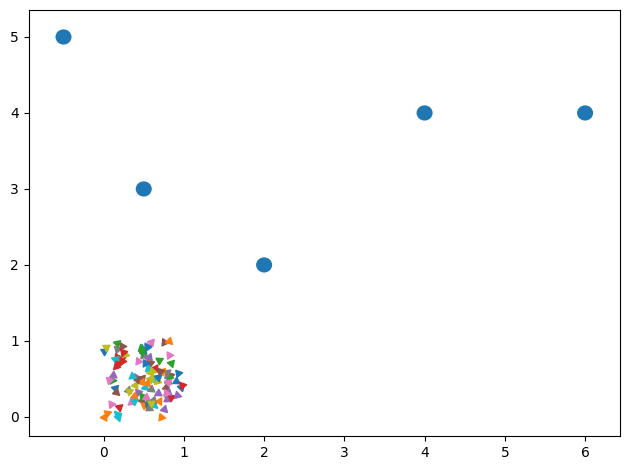

In [ ]:
plt.figure()
positions = [np.array([-.5, 5.]), np.array([.5, 3]), np.array([2.,2.]), np.array([4.,4.]), np.array([6.,4.])]
radii = [0.1, 0.1, 0.1, 0.1, 0.1]
obsset = obstacleset(positions, radii)
F = flockset(100, [0, 1], [0, 1], 0.1, 1., obsset, 12)
fig = plotobstacleset(obsset)
plotflockset(F, fig)
plt.show()

...seems legit

2. We will create the state of the flock at different times

<Figure size 640x480 with 0 Axes>

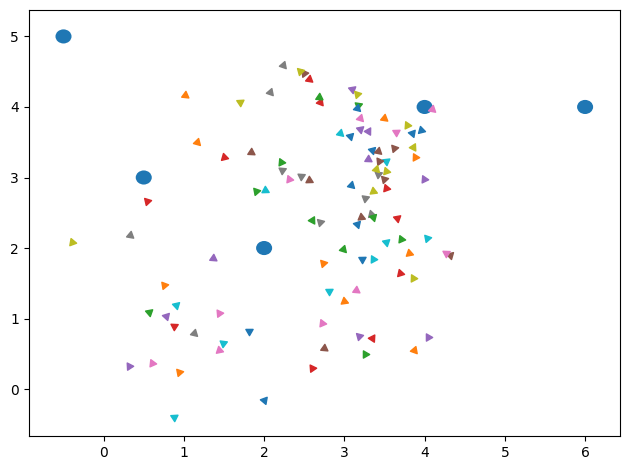

<Figure size 640x480 with 0 Axes>

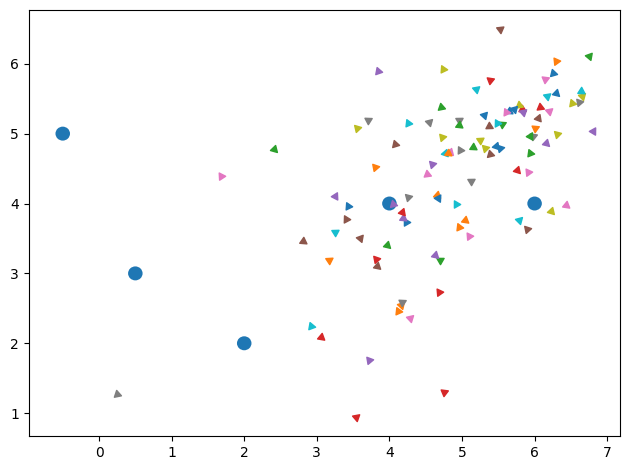

<Figure size 640x480 with 0 Axes>

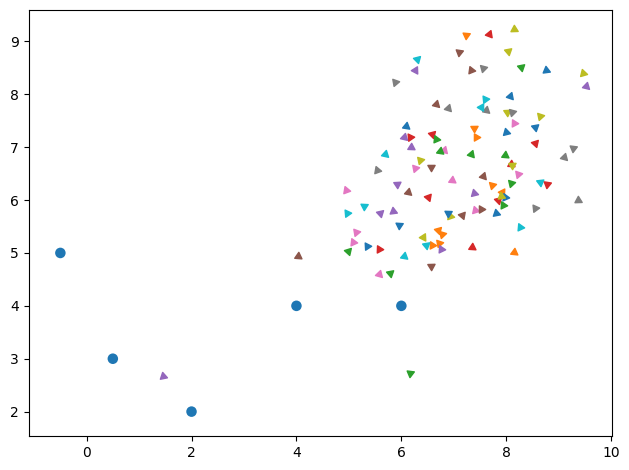

<Figure size 640x480 with 0 Axes>

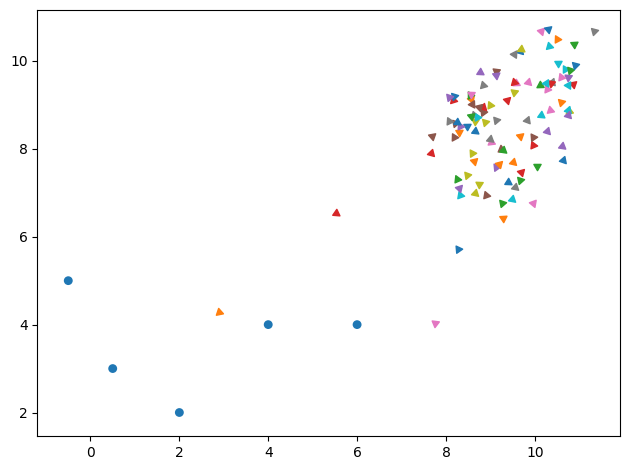

<Figure size 640x480 with 0 Axes>

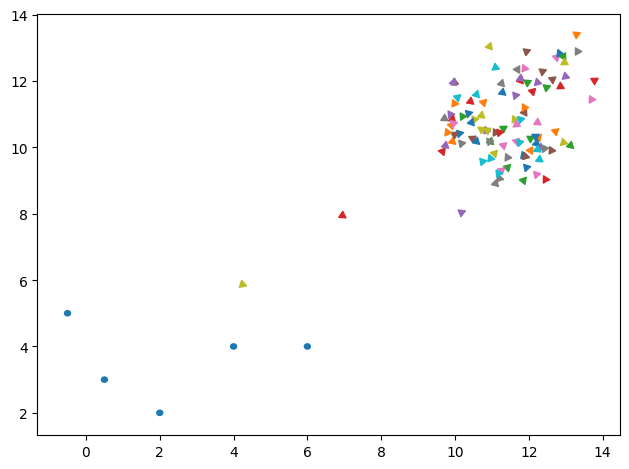

<Figure size 640x480 with 0 Axes>

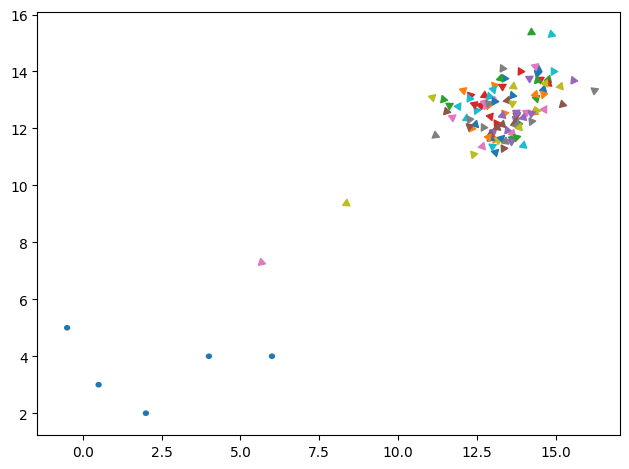

<Figure size 640x480 with 0 Axes>

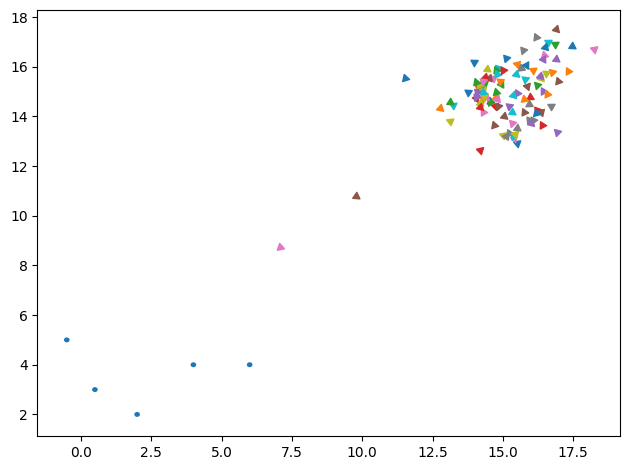

<Figure size 640x480 with 0 Axes>

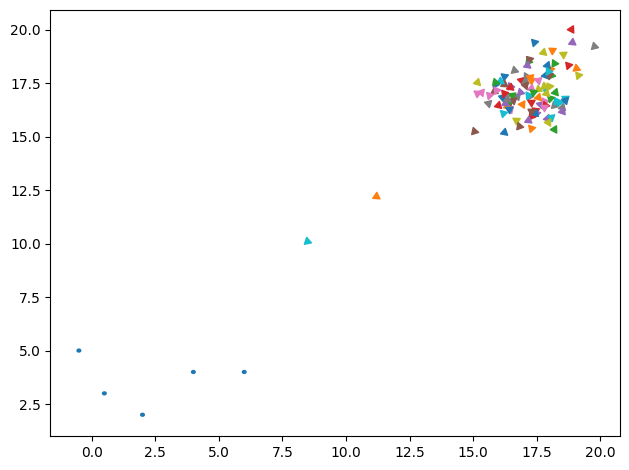

<Figure size 640x480 with 0 Axes>

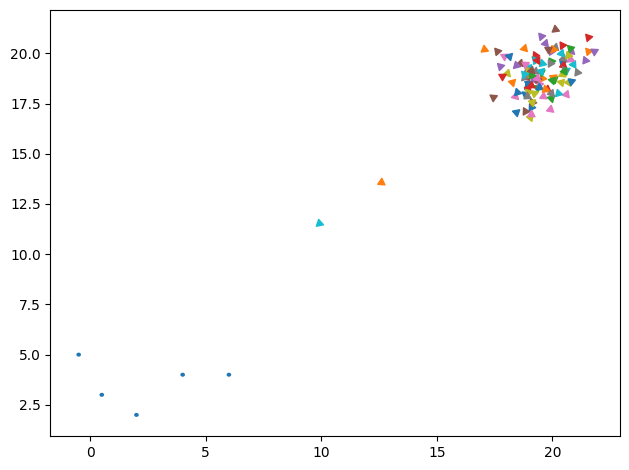

<Figure size 640x480 with 0 Axes>

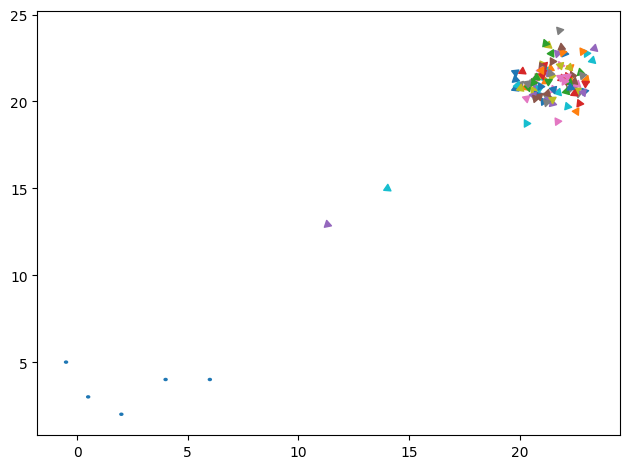

In [ ]:
for ind in range(10):
    plt.figure()
    F = flock(F, obsset)
    fig = plotobstacleset(obsset)
    plotflockset(F, fig)
    fig.tight_layout()
    plt.show()

# Programming assignment: Beedroids [Fall 2023/24] 🐝 🍯 🌻 🐦

In this assignment, you will design a simulation of a hive of bees that are attracted to several attractors for a set amount of time, after which the attractors become neutral objects for bees that have already visited them. You will design a scene with at least 4 avoidance and 4 attracting objects, and observe how the bees navigate through the scene.

## **Instructions:**

1. **Design several attractors:** Create several attractors (such as flowers) in the scene that the bees will be attracted to for a set amount of time. The attractors should have a noticeable visual cue that makes them easily distinguishable from the other objects in the scene.
2. **Attraction behavior:** Implement a behavior for the bees that causes them to move towards the attractors. You may use any algorithm or technique to achieve this, but it should be able to handle multiple attractors and should not cause the bees to get stuck or collide with each other.
3. **Time-limited attraction:** Implement a timer that causes the attractors to become neutral objects after a set amount of time for the bee that has visited it. _The attractor cannot host more than 3 bees at the same time._ The bees should stop being attracted to the attractors after this time, and the attractors should no longer have any effect on a bee that has visited them.
4. **Avoidance behavior:** Create at least four avoidance objects (such as obstacles) in the scene that the bees should avoid. The avoidance objects should have a noticeable visual cue that makes them easily distinguishable from the other objects in the scene.
5. **Avoidance behavior:** Implement a behavior for the bees that causes them to avoid the avoidance objects. You may use any algorithm or technique to achieve this, but it should be able to handle multiple avoidance objects and should not cause the bees to get stuck or collide with each other.
6. Report: Write a report describing your implementation of the simulation, the algorithms and techniques used for attraction and avoidance behaviors, and the challenges faced during the implementation. Include screenshots or videos of the simulation in action, and discuss the behavior of the bees in response to the attractors and avoidance objects.

## **GRADING**
- **Attractors** (20 points): Attractors are visually distinct and easily identifiable, and the bees are attracted to them for a set amount of time.
- **Attraction behavior** (20 points): The attraction behavior works correctly and handles multiple attractors without causing collisions or getting the bees stuck.
- **Time-limited attraction** (20 points): The attractors become neutral objects after a set amount of time, and the bees stop being attracted to them.
- **Avoidance objects** (20 points): Avoidance objects are visually distinct and easily identifiable, and the bees avoid them correctly.
- **Report** (20 points): A well-written report (max 2 pages, 11pt font size) is submitted, including a description of the implementation, the algorithms and techniques used for attraction and avoidance behaviors, and the challenges faced during the implementation. Any context exceeding 2 pages will not be included in grading.
- **Bonus** (10 points) Animate several iterations and make and submit a 5 second video.

**Notes:**

1. You are free to use chatGPT for help. However, you should not use code generated by chatGPT directly and you should mention which part of the code is chatGPT in the comments. Your code will be checked for verbatim copying from chatGPT.
2. You are not allowed to use external modules/libraries in your implementations except those already in the notebook, but you can use them for testing your code.
3. You will upload your submission as a Python notebook to ODTUClass.

(c) Huseyin Hacihabiboglu, 2022-2024